In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from scipy.signal import deconvolve
# print full dataframe
pd.set_option('display.max_rows', None)
from scipy.signal import argrelextrema
from numpy.polynomial.polynomial import Polynomial
from scipy.signal import savgol_filter, argrelextrema
from matplotlib.animation import FuncAnimation

In [2]:
def txt_to_dataframe(filename):
    data = pd.read_csv(filename, sep='\t', skiprows = 208)
    # Rename first column
    data.rename(columns={data.columns[0]: 'Time Photons'}, inplace=True)
    # Separate columns into two columns
    data[['Time', 'Photons']] = data['Time Photons'].str.split(expand=True)
    # Remove first column
    data = data.drop(columns=['Time Photons'])
    # Convert 'Photons' to numeric
    data['Photons'] = pd.to_numeric(data['Photons'], errors='coerce')
    data['Time'] = pd.to_numeric(data['Time'], errors='coerce')
    # Remove leading and trailing rows where 'Photons' is 0
    mask = data['Photons'].ne(0)
    data = data.loc[mask.idxmax():mask[::-1].idxmax()]
    # Remove Nans
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    return data

In [3]:
df= txt_to_dataframe('data/Hb1C.asc')
df_IRF = txt_to_dataframe('data/IRF/IRF1.asc')



In [4]:
def df_cut_df(df, start, end):
    mask = (df['Time'] >= start) & (df['Time'] <= end)
    return df.loc[mask]
def find_highest_peak(df):
    #Return Time with Highest Photons
    max_photons = df['Photons'].max()
    max_time = df.loc[df['Photons'].idxmax()]['Time']
    return max_time
def df_cut_max(df, end):
    mask = (df['Time'] <= end)
    return df.loc[mask]

df_cutted = df_cut_df(df, find_highest_peak(df), 1)

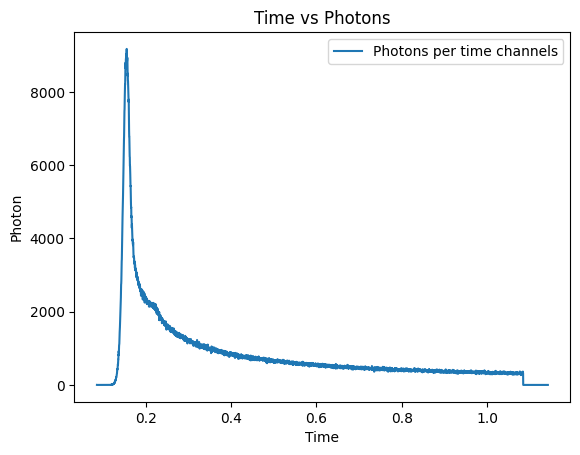

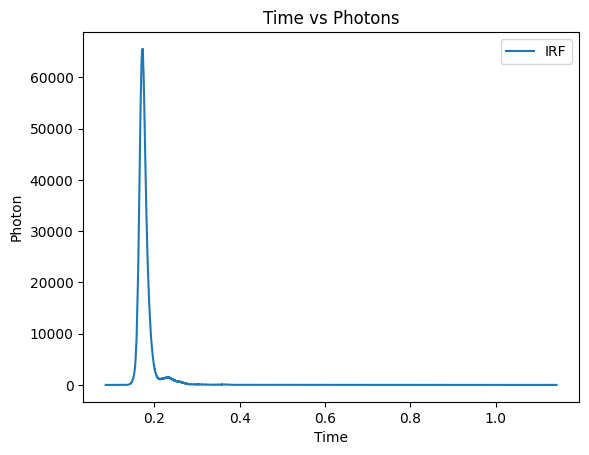

In [215]:
def simple_plot(df, title):
    plt.plot(df['Time'], df['Photons'], label=title)
    plt.xlabel('Time')
    plt.ylabel('Photon')
    plt.title('Time vs Photons')
    #reduce number of ticks on x and y axis
    plt.locator_params(axis='x', nbins=10)
    plt.locator_params(axis='y', nbins=10)
    plt.legend()
    plt.show()
simple_plot(df, "Photons per time channels")
simple_plot(df_IRF, "IRF")


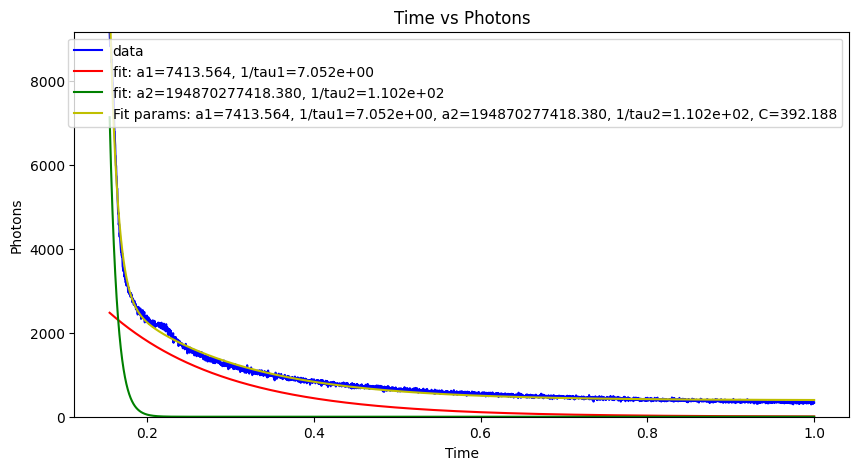

In [227]:
def fit_func(x, a, b, c, d, e):
    return a * np.exp(-b * x) + c * np.exp(-d * x) + e 
def time_photons_plot(df):
    x_data = df['Time']
    y_data = df['Photons']
    # Plot size
    plt.figure(figsize=(10, 5))

    # Fit the data
    popt, pcov = curve_fit(fit_func, x_data, y_data, p0=(-1, 1e-6, -1, 1e-6, 1))

    # Create the individual exponentials and their sum
    y_fit1 = popt[0] * np.exp(-popt[1] * x_data)
    y_fit2 = popt[2] * np.exp(-popt[3] * x_data)
    y_fit_total = fit_func(x_data, *popt)

    plt.plot(x_data, y_data, 'b-', label='data')
    plt.plot(x_data, y_fit1, 'r-', label='fit: a1=%5.3f, 1/tau1=%5.3e' % tuple(popt[0:2]))
    plt.plot(x_data, y_fit2, 'g-', label='fit: a2=%5.3f, 1/tau2=%5.3e' % tuple(popt[2:4]))
    plt.plot(x_data, y_fit_total, 'y-', label='Fit params: a1=%5.3f, 1/tau1=%5.3e, a2=%5.3f, 1/tau2=%5.3e, C=%5.3f' % tuple(popt))

    plt.xlabel('Time')
    plt.ylabel('Photons')
    # plt.yscale('log')
    plt.title('Time vs Photons')
    plt.legend()

    # Change number of ticks on x and y axis
    # plt.locator_params(axis='x', nbins=10)
    # plt.locator_params(axis='y', nbins=10)
    # Change Y limit to max photons
    plt.ylim(0, df['Photons'].max())
    plt.show()

time_photons_plot(df_cutted)

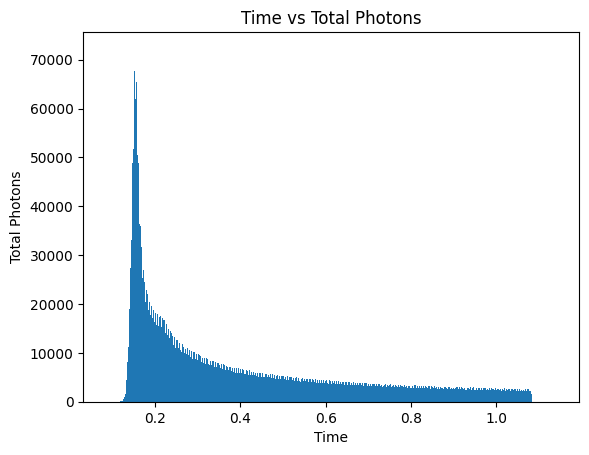

In [7]:
def df_to_histogram(df, bins = 'auto'):
    # Convert 'Time' and 'Photons' to numeric and remove rows with non-finite 'Time' values
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df['Photons'] = pd.to_numeric(df['Photons'], errors='coerce')
    df = df[np.isfinite(df['Time'])]
    # Calculate bin edges using Freedman-Diaconis rule
    # bin_edges = np.histogram_bin_edges(df['Time'], bins='fd')
    bin_edges = np.histogram_bin_edges(df['Time'], bins=500)
    # Calculate bin indices for each 'Time' value
    bin_indices = np.digitize(df['Time'], bin_edges)
    # Calculate total 'Photons' within each bin
    photons_per_bin = [df['Photons'][bin_indices == i].sum() for i in range(1, len(bin_edges))]
    df_hist = pd.DataFrame({'Time': bin_edges[:-1], 'Photons': photons_per_bin})
    return df_hist
    
def df_to_histogram_edges(df_IRF, df_hist):
    # Create a new DataFrame with the same 'Time' edges as df_hist and zeros for 'Photons'
    df_aligned = pd.DataFrame({'Time': df_hist['Time'], 'Photons': np.zeros(len(df_hist))})
    
    # Calculate the bin indices for df_IRF using the edges from df_hist
    bin_indices_IRF = np.digitize(df_IRF['Time'], df_hist['Time'])
    
    # Sum the 'Photons' from df_IRF into the aligned bins of df_aligned
    for i in range(1, len(df_hist['Time']) + 1):
        mask = bin_indices_IRF == i
        df_aligned['Photons'].iloc[i - 1] = df_IRF['Photons'][mask].sum()
    
    return df_aligned


df_hist = df_to_histogram(df)
df_IRF_hist = df_to_histogram_edges(df_IRF, df_hist)
def plot_histogram(df_hist):
    plt.bar(df_hist['Time'], df_hist['Photons'], width=np.diff(df_hist['Time'])[0])
    plt.xlabel('Time')
    plt.ylabel('Total Photons')
    plt.title('Time vs Total Photons')
    plt.show()
plot_histogram(df_hist)



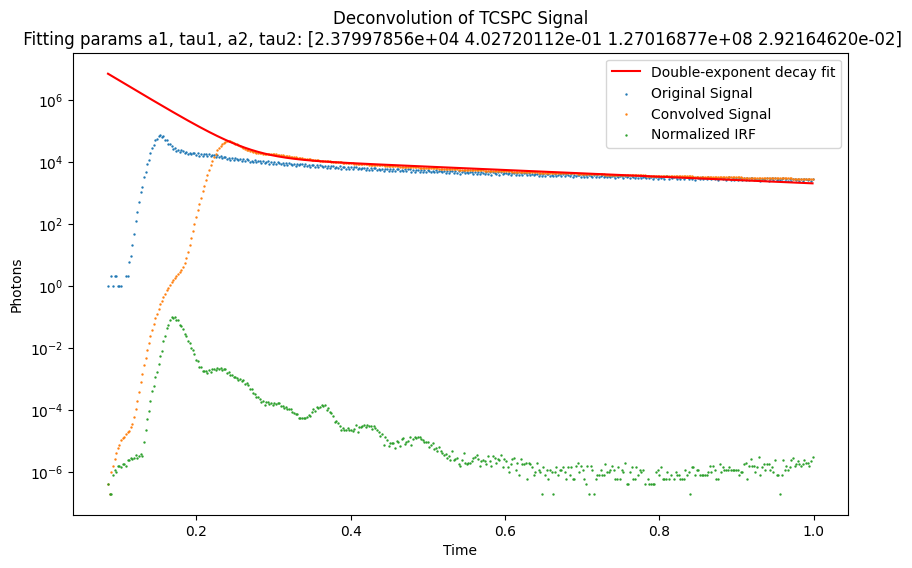

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Bi-exponential decay function
def bi_exponential_decay(time, a1, t1, a2, t2):
    return a1 * np.exp(-time / t1) + a2 * np.exp(-time / t2)

# Deconvolution function
def deconvolve_signal(df, df_IRF):
    # Ensure the data is sorted by time
    df = df.sort_values(by='Time')
    df_IRF = df_IRF.sort_values(by='Time')

    df = df_to_histogram(df, bins = 1000)
    df_IRF = df_to_histogram_edges(df_IRF, df)
    
    df = df_cut_max(df, 1)
    df_IRF = df_cut_max(df_IRF, 1)
    
    # Normalize the IRF
    df_IRF['Photons'] /= np.sum(df_IRF['Photons'])

    
    # Perform the convolution of the decay with the IRF
    convolved_signal = np.convolve(df['Photons'], df_IRF['Photons'], mode='full')[:len(df)]



    # Find the index of the maximum value of the signal
    max_index = np.argmax(convolved_signal)
    # Slice the time and convolved signal arrays from the maximum value to the end
    time_slice = df['Time'][max_index:]
    convolved_signal_slice = convolved_signal[max_index:]

    # Initial guess for the parameters [a1, t1, a2, t2]
    initial_guess = [max(df['Photons']), 1, max(df['Photons'])/2, 1]

    # Fit the bi-exponential decay model to the convolved signal
    popt, pcov = curve_fit(bi_exponential_decay, time_slice, convolved_signal_slice, p0=initial_guess, maxfev=10000, bounds=([-np.inf, 0, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf]))

    
    
    # Plot the original signal, the IRF, and the fitted model
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Time'], df['Photons'], label='Original Signal', s = 0.5)
    plt.scatter(df['Time'], convolved_signal, label='Convolved Signal', s = 0.5)
    plt.plot(df['Time'], bi_exponential_decay(df['Time'], *popt), label='Double-exponent decay fit', c = 'r', linewidth = 1.5)
    plt.scatter(df_IRF['Time'], df_IRF['Photons'], label='Normalized IRF', s = 0.5)
    
    # log scale
    plt.yscale('log')
    plt.xlabel('Time')
    plt.ylabel('Photons')
    plt.title('Deconvolution of TCSPC Signal\n Fitting params a1, tau1, a2, tau2: ' + str(popt))
    plt.legend()
    plt.show()

    return popt

# Example usage:
# Assuming df and df_IRF are your DataFrames with 'Photons' and 'Time' columns
parameters = deconvolve_signal(df, df_IRF)


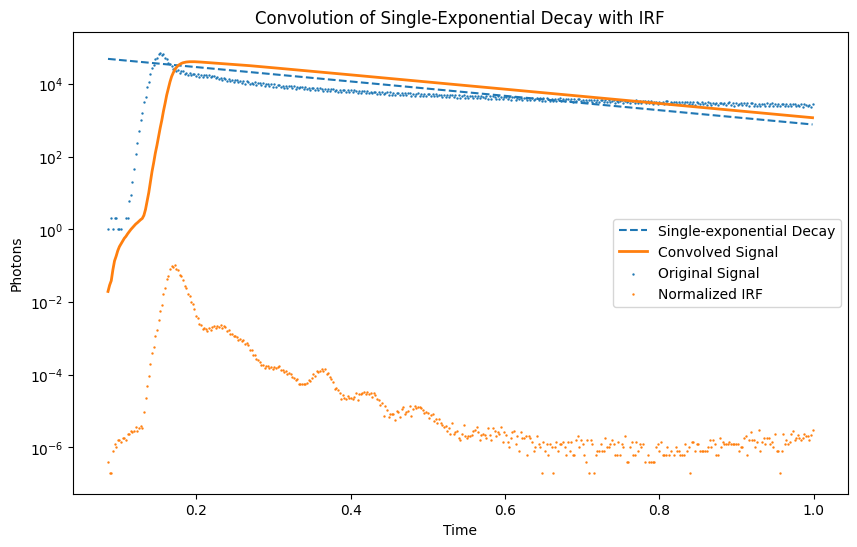

In [19]:
#The first moment of a photon distribution
def first_moment(df):
    M = np.sum(df['Time']*df['Photons'])/np.sum(df['Photons'])
    return M

#The fluorescence lifetime (of a single-exponential decay approximation) is the difference of the first moment of the fluorescence and the first moment of the IRF
def fluorescence_lifetime(df, df_IRF):
    M = first_moment(df)
    M_IRF = first_moment(df_IRF)
    tau = M - M_IRF
    return tau

def single_exponential_decay(time, a, tau):
    return a * np.exp(-time / tau)

def plot_convolution(df, df_IRF):
    # Ensure the data is sorted by time
    tau = fluorescence_lifetime(df, df_IRF)
    df = df.sort_values(by='Time')
    df_IRF = df_IRF.sort_values(by='Time')

    df = df_to_histogram(df, bins = 1000)
    df_IRF = df_to_histogram_edges(df_IRF, df)
    
    df = df_cut_max(df, 1)
    df_IRF = df_cut_max(df_IRF, 1)

    # Normalize the IRF
    df_IRF['Photons'] /= np.sum(df_IRF['Photons'])

    # Generate the single-exponential decay using the fluorescence lifetime tau
    decay = single_exponential_decay(df['Time'], np.max(df['Photons']), tau)

    # Perform the convolution of the decay with the IRF
    convolved_signal = np.convolve(decay, df_IRF['Photons'], mode='full')[:len(df)]

    # Plot the original signal, the IRF, the single-exponential decay, and the convolved signal
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Time'], df['Photons'], label='Original Signal', marker='o', s = 0.5)
    plt.plot(df['Time'], decay, label='Single-exponential Decay', linestyle='--')
    plt.scatter(df_IRF['Time'], df_IRF['Photons'], label='Normalized IRF', s = 0.5)
    plt.plot(df['Time'], convolved_signal, label='Convolved Signal', linewidth=2)
    
    plt.xlabel('Time')
    plt.ylabel('Photons')
    plt.yscale('log')
    plt.title('Convolution of Single-Exponential Decay with IRF')
    plt.legend()
    plt.show()
plot_convolution(df, df_IRF)
